In [1]:
using Lux, ADTypes, Optimisers, Printf, Random, Reactant, Statistics, CairoMakie

In [2]:
function generate_data(rng::AbstractRNG)
    x = reshape(collect(range(-2.0f0, 2.0f0, 128)), (1, 128))
    y = evalpoly.(x, ((0, -2, 1),)) .+ randn(rng, Float32, (1, 128)) .* 0.1f0
    return (x, y)
end

generate_data (generic function with 1 method)

In [3]:
rng = MersenneTwister()
Random.seed!(rng, 12345)

(x, y) = generate_data(rng)

(Float32[-2.0 -1.968504 … 1.968504 2.0], Float32[8.080871 7.562357 … -0.15877295 -0.06777584])

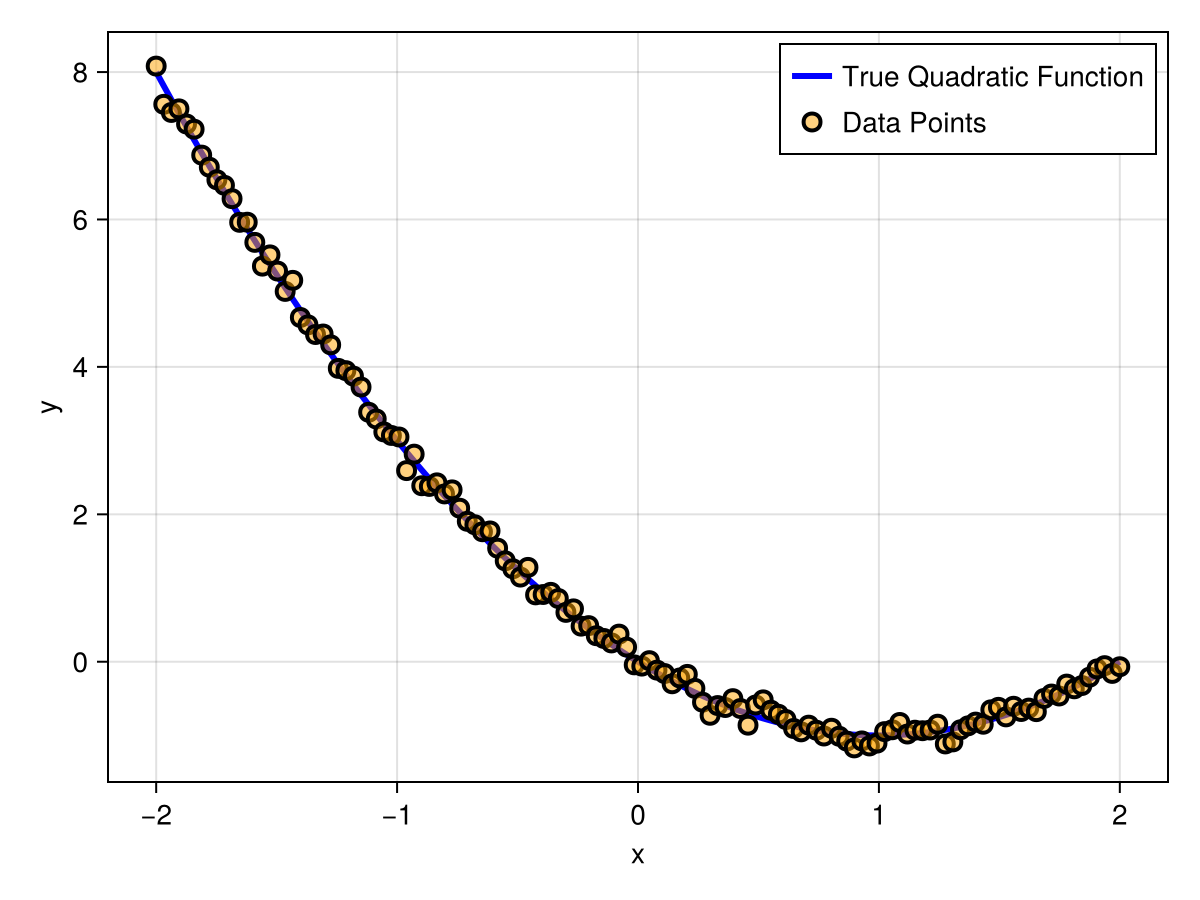

In [4]:
begin
    fig = Figure()
    ax = CairoMakie.Axis(fig[1, 1]; xlabel="x", ylabel="y")

    l = lines!(ax, x[1, :], x -> evalpoly(x, (0, -2, 1)); linewidth=3, color=:blue)
    s = scatter!(
        ax,
        x[1, :],
        y[1, :];
        markersize=12,
        alpha=0.5,
        color=:orange,
        strokecolor=:black,
        strokewidth=2,
    )

    axislegend(ax, [l, s], ["True Quadratic Function", "Data Points"])

    fig
end

In [5]:
model = Chain(Dense(1 => 16, relu), Dense(16 => 1))

Chain(
    layer_1 = Dense(1 => 16, relu),     # 32 parameters
    layer_2 = Dense(16 => 1),           # 17 parameters
)         # Total: 49 parameters,
          #        plus 0 states.

In [6]:
opt = Adam(0.03f0)

Adam(eta=0.03, beta=(0.9, 0.999), epsilon=1.0e-8)

In [7]:
const loss_function = MSELoss()

const cdev = cpu_device()
const xdev = reactant_device()

ps, st = xdev(Lux.setup(rng, model))

((layer_1 = (weight = ConcretePJRTArray{Float32, 2, 1, Reactant.Sharding.ShardInfo{Reactant.Sharding.NoSharding, Nothing}}(Float32[2.2569513; 1.8385266; … ; -1.4312565; 0.34652048;;]), bias = ConcretePJRTArray{Float32, 1, 1, Reactant.Sharding.ShardInfo{Reactant.Sharding.NoSharding, Nothing}}(Float32[0.9155488, -0.005158901, 0.5026965, -0.84174657, -0.9167142, -0.14881086, -0.8202727, 0.19286752, 0.60171676, 0.951689, 0.4595859, -0.33281517, -0.692657, 0.4369135, 0.3800323, 0.61768365])), layer_2 = (weight = ConcretePJRTArray{Float32, 2, 1, Reactant.Sharding.ShardInfo{Reactant.Sharding.NoSharding, Nothing}}(Float32[0.20061705 0.22529833 … -0.13759731 0.08034529]), bias = ConcretePJRTArray{Float32, 1, 1, Reactant.Sharding.ShardInfo{Reactant.Sharding.NoSharding, Nothing}}(Float32[0.06066203]))), (layer_1 = NamedTuple(), layer_2 = NamedTuple()))

In [8]:
tstate = Training.TrainState(model, ps, st, opt)

TrainState
    model: Chain{@NamedTuple{layer_1::Dense{typeof(relu), Int64, Int64, Nothing, Nothing, Static.True}, layer_2::Dense{typeof(identity), Int64, Int64, Nothing, Nothing, Static.True}}, Nothing}((layer_1 = Dense(1 => 16, relu), layer_2 = Dense(16 => 1)), nothing)
    # of parameters: 49
    # of states: 0
    optimizer: ReactantOptimiser{Adam{ConcretePJRTNumber{Float32, 1, ShardInfo{NoSharding, Nothing}}, Tuple{ConcretePJRTNumber{Float64, 1, ShardInfo{NoSharding, Nothing}}, ConcretePJRTNumber{Float64, 1, ShardInfo{NoSharding, Nothing}}}, ConcretePJRTNumber{Float64, 1, ShardInfo{NoSharding, Nothing}}}}(Adam(eta=ConcretePJRTNumber{Float32, 1, Reactant.Sharding.ShardInfo{Reactant.Sharding.NoSharding, Nothing}}(0.03f0), beta=(ConcretePJRTNumber{Float64, 1, Reactant.Sharding.ShardInfo{Reactant.Sharding.NoSharding, Nothing}}(0.9), ConcretePJRTNumber{Float64, 1, Reactant.Sharding.ShardInfo{Reactant.Sharding.NoSharding, Nothing}}(0.999)), epsilon=ConcretePJRTNumber{Float64, 1, Reactan

In [9]:
vjp_rule = AutoEnzyme()

AutoEnzyme()

In [10]:
function main(tstate::Training.TrainState, vjp, data, epochs)
    data = xdev(data)
    for epoch in 1:epochs
        _, loss, _, tstate = Training.single_train_step!(vjp, loss_function, data, tstate)
        if epoch % 50 == 1 || epoch == epochs
            @printf "Epoch: %3d \t Loss: %.5g\n" epoch loss
        end
    end
    return tstate
end

tstate = main(tstate, vjp_rule, (x, y), 250)

Epoch:   1 	 Loss: 12.499
Epoch:  51 	 Loss: 0.090343
Epoch: 101 	 Loss: 0.0405
Epoch: 151 	 Loss: 0.024803
Epoch: 201 	 Loss: 0.017711
Epoch: 250 	 Loss: 0.01466


TrainState
    model: Chain{@NamedTuple{layer_1::Dense{typeof(relu), Int64, Int64, Nothing, Nothing, Static.True}, layer_2::Dense{typeof(identity), Int64, Int64, Nothing, Nothing, Static.True}}, Nothing}((layer_1 = Dense(1 => 16, relu), layer_2 = Dense(16 => 1)), nothing)
    # of parameters: 49
    # of states: 0
    optimizer: ReactantOptimiser{Adam{ConcretePJRTNumber{Float32, 1, ShardInfo{NoSharding, Nothing}}, Tuple{ConcretePJRTNumber{Float64, 1, ShardInfo{NoSharding, Nothing}}, ConcretePJRTNumber{Float64, 1, ShardInfo{NoSharding, Nothing}}}, ConcretePJRTNumber{Float64, 1, ShardInfo{NoSharding, Nothing}}}}(Adam(eta=ConcretePJRTNumber{Float32, 1, Reactant.Sharding.ShardInfo{Reactant.Sharding.NoSharding, Nothing}}(0.03f0), beta=(ConcretePJRTNumber{Float64, 1, Reactant.Sharding.ShardInfo{Reactant.Sharding.NoSharding, Nothing}}(0.9), ConcretePJRTNumber{Float64, 1, Reactant.Sharding.ShardInfo{Reactant.Sharding.NoSharding, Nothing}}(0.999)), epsilon=ConcretePJRTNumber{Float64, 1, Reactan

In [11]:
forward_pass = Reactant.with_config(;
    dot_general_precision=PrecisionConfig.HIGH,
    convolution_precision=PrecisionConfig.HIGH,
) do
    @compile Lux.apply(tstate.model, xdev(x), tstate.parameters, Lux.testmode(tstate.states))
end

y_pred = cdev(
    first(
        forward_pass(tstate.model, xdev(x), tstate.parameters, Lux.testmode(tstate.states))
    ),
)

1×128 Matrix{Float32}:
 7.71788  7.56951  7.42115  7.27278  …  -0.254123  -0.225575  -0.197027

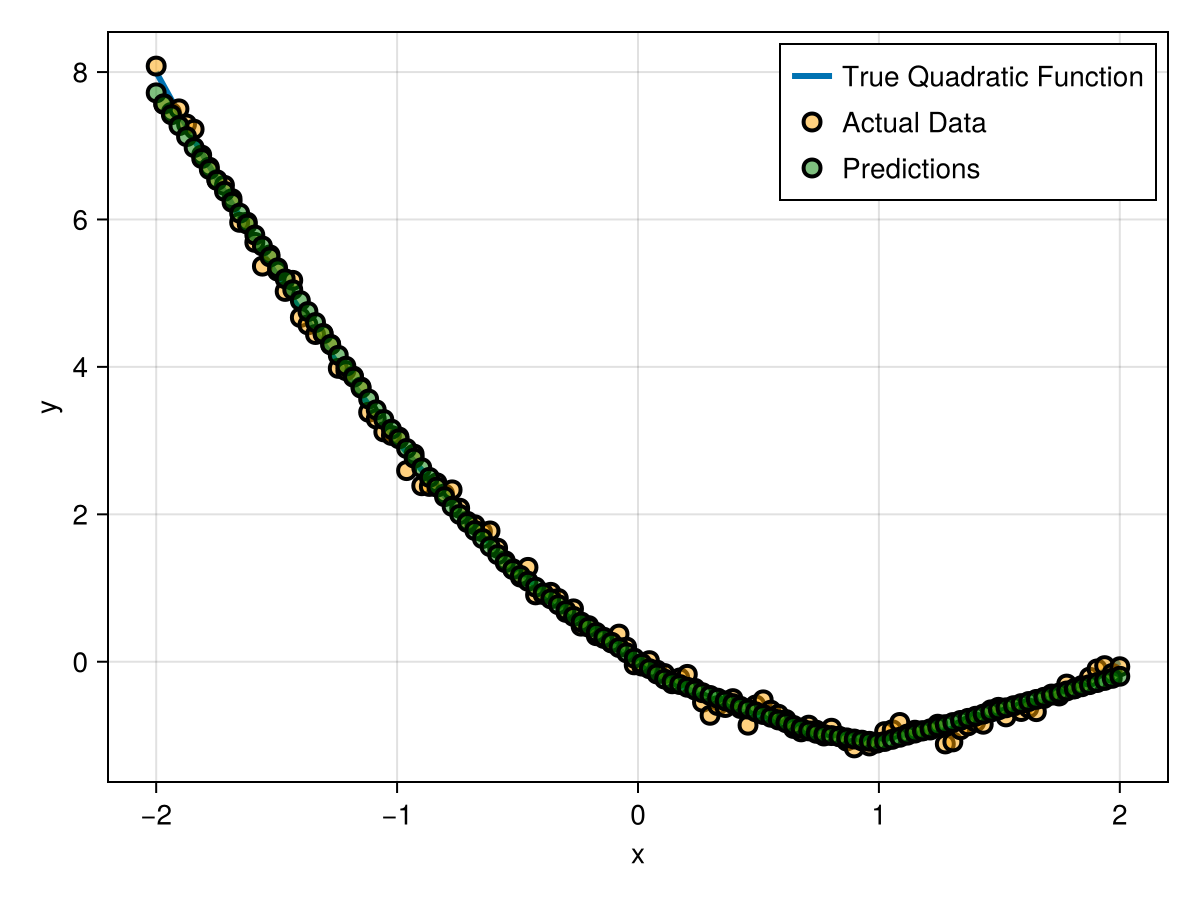

In [12]:
begin
    fig = Figure()
    ax = CairoMakie.Axis(fig[1, 1]; xlabel="x", ylabel="y")

    l = lines!(ax, x[1, :], x -> evalpoly(x, (0, -2, 1)); linewidth=3)
    s1 = scatter!(
        ax,
        x[1, :],
        y[1, :];
        markersize=12,
        alpha=0.5,
        color=:orange,
        strokecolor=:black,
        strokewidth=2,
    )
    s2 = scatter!(
        ax,
        x[1, :],
        y_pred[1, :];
        markersize=12,
        alpha=0.5,
        color=:green,
        strokecolor=:black,
        strokewidth=2,
    )

    axislegend(ax, [l, s1, s2], ["True Quadratic Function", "Actual Data", "Predictions"])

    fig
end